In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from itertools import combinations 
import ast
import math

from sklearn.preprocessing import StandardScaler, normalize
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import datetime
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

### Retrieve data

In [2]:
# Read dataset
data_folder = './data/'
data=pd.read_csv(data_folder + 'marketing_campaign.csv',header=0,sep=';', index_col = 'ID')

In [3]:
data.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
ID,,,,,,,,,,,,,,,,,,,,,
5524,1957,Graduation,Single,58138.0,0,0,4/9/2012,58,635,88,...,7,0,0,0,0,0,0,3,11,1
2174,1954,Graduation,Single,46344.0,1,1,8/3/2014,38,11,1,...,5,0,0,0,0,0,0,3,11,0
4141,1965,Graduation,Together,71613.0,0,0,21/8/2013,26,426,49,...,4,0,0,0,0,0,0,3,11,0
6182,1984,Graduation,Together,26646.0,1,0,10/2/2014,26,11,4,...,6,0,0,0,0,0,0,3,11,0
5324,1981,PhD,Married,58293.0,1,0,19/1/2014,94,173,43,...,5,0,0,0,0,0,0,3,11,0


### Analyze data and rename columns

In [4]:
# Calculate client's age
data['Age'] = 2021 - data['Year_Birth']

# Calculate total spent
data['Total_Spent'] = data['MntWines'] + data['MntFruits'] + data['MntMeatProducts'] + data['MntFishProducts'] + data['MntSweetProducts'] + data['MntGoldProds']

#Seniority variable creation
last_date = date(2021, 12, 13)

In [5]:
# Calculate clients's seniority
data['Seniority']=pd.to_datetime(data['Dt_Customer'], dayfirst=True, format='%d/%m/%Y')
data['Seniority'] = pd.to_numeric(data['Seniority'].dt.date.apply(lambda x: (last_date - x)).dt.days, downcast='integer')

# Rename some columns
data=data.rename(columns={'NumWebPurchases': "Web_Purchases",
                          'NumCatalogPurchases':'Catalog_Purchases',
                          'NumStorePurchases':'Store_Purchases', 
                          'NumWebVisitsMonth':'Web_Visits_Month',
                          'MntWines': "Wines",
                          'MntFruits':'Fruits',
                          'MntMeatProducts':'Meat',
                          'MntFishProducts':'Fish',
                          'MntSweetProducts':'Sweets',
                          'MntGoldProds':'Gold'})

# Calculate the amount of children that a client has
data['Children'] = data['Kidhome'] + data['Teenhome']
data['Has_Child'] = np.where(data.Children > 0, 1, 0)

# Filter just relevant client's features
data=data[['Age','Education','Marital_Status','Income','Total_Spent','Seniority','Has_Child', 'Children', 'Wines','Fruits','Meat','Fish','Sweets','Gold','Web_Purchases','Catalog_Purchases','Store_Purchases','Web_Visits_Month']]
data.head()

,Age,Education,Marital_Status,Income,Total_Spent,Seniority,Has_Child,Children,Wines,Fruits,Meat,Fish,Sweets,Gold,Web_Purchases,Catalog_Purchases,Store_Purchases,Web_Visits_Month
ID,,,,,,,,,,,,,,,,,,
5524,64,Graduation,Single,58138.0,1617,3387,0,0,635,88,546,172,88,88,8,10,4,7
2174,67,Graduation,Single,46344.0,27,2837,1,2,11,1,6,2,1,6,1,1,2,5
4141,56,Graduation,Together,71613.0,776,3036,0,0,426,49,127,111,21,42,8,2,10,4
6182,37,Graduation,Together,26646.0,53,2863,1,1,11,4,20,10,3,5,2,0,4,6
5324,40,PhD,Married,58293.0,422,2885,1,1,173,43,118,46,27,15,5,3,6,5


In [6]:
def plot_hist(columns, bins):
    features = len(columns)
    COLUMNS = 4
    ROWS = math.ceil(features/COLUMNS)

    fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(16,10))
    
    for i in range(0, features):
        current_column = i % COLUMNS
        current_row = i//COLUMNS
        # Get the axis where to add the plot
        ax = axs[current_row, current_column]
        data[columns[i]].hist(bins=bins[i], ax=ax, alpha=0.6)
        ax.set_title(columns[i])
        
    plt.tight_layout()

In [7]:
def plot_bars(columns):
    features = len(columns)
    COLUMNS = 4
    fig, axs = plt.subplots(1, COLUMNS, figsize=(16,4))
    
    for i in range(0, features):
        current_column = i % COLUMNS
        ax = axs[current_column]
        data[columns[i]].value_counts().plot(ax=ax, kind='bar')
        ax.set_title(columns[i])
        
    plt.tight_layout()

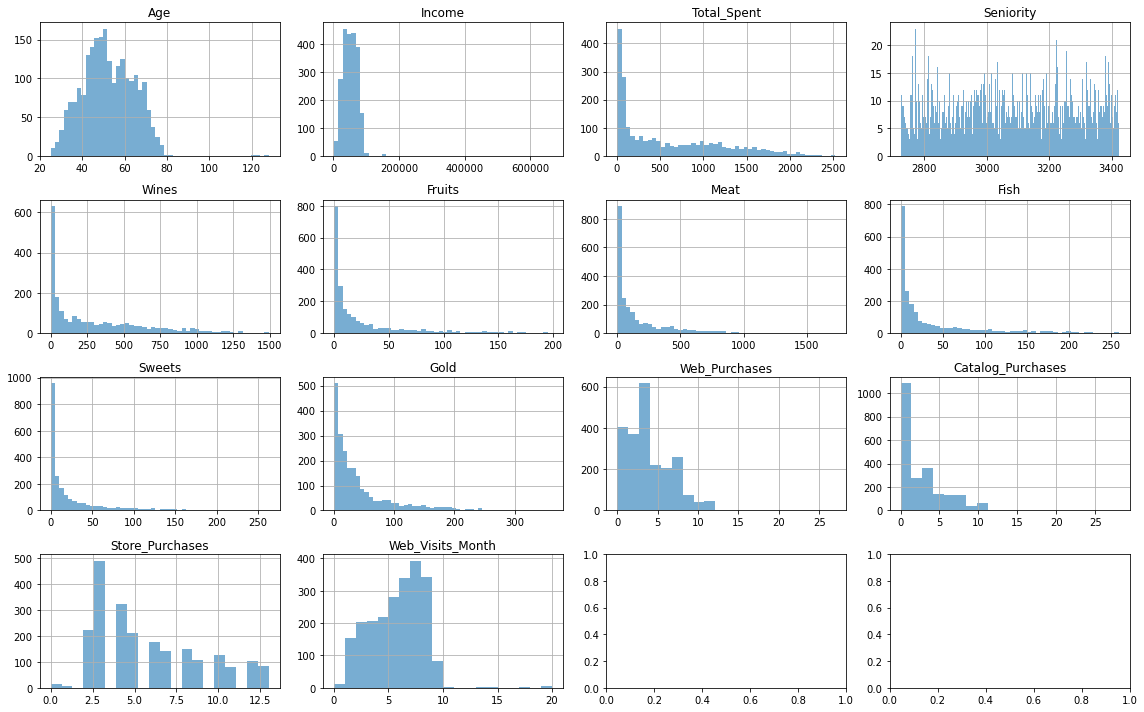

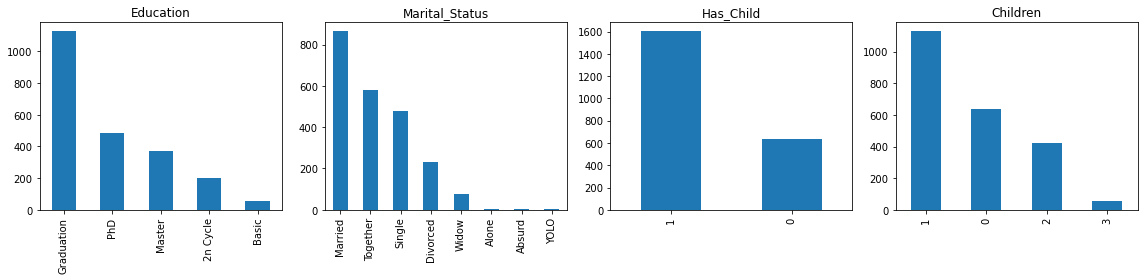

In [8]:
# Plot features after cleaning the data
hist_columns = ['Age', 'Income', 'Total_Spent', 'Seniority', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'Web_Purchases', 'Catalog_Purchases', 'Store_Purchases', 'Web_Visits_Month']
bar_columns = ['Education', 'Marital_Status', 'Has_Child', 'Children']

bins = [50, 50, 50, 250, 50, 50, 50, 50, 50, 50, 20, 20, 20, 20]

plot_hist(hist_columns, bins)
plot_bars(bar_columns)

### Clean data

In [9]:
# Check amount of initial null values
print('Amount of null values',len(data[data.isna().any(axis=1)]))
print(data.mean().mean())

Amount of null values 24
3538.0089573797704


In [10]:
# Fill null values with mean income amount according its education level
data['Income'].fillna(data.groupby('Education')['Income'].transform('mean'), inplace=True)

In [11]:
# Check the amount of null values after cleaning the data
print('Amount of null values after cleaning the data',len(data[data.isna().any(axis=1)]))

Amount of null values after cleaning the data 0


In [12]:
# Check max and min values in Income column
my_max = data['Income'].loc[data['Income'].idxmax()]
print(my_max)
my_min = data['Income'].loc[data['Income'].idxmin()]
print(my_min)

666666.0
1730.0


In [13]:
# Remove outliers
data = data[data['Age'] < 100]
data = data[data['Income'] < 600000]

In [14]:
data.head()

,Age,Education,Marital_Status,Income,Total_Spent,Seniority,Has_Child,Children,Wines,Fruits,Meat,Fish,Sweets,Gold,Web_Purchases,Catalog_Purchases,Store_Purchases,Web_Visits_Month
ID,,,,,,,,,,,,,,,,,,
5524,64,Graduation,Single,58138.0,1617,3387,0,0,635,88,546,172,88,88,8,10,4,7
2174,67,Graduation,Single,46344.0,27,2837,1,2,11,1,6,2,1,6,1,1,2,5
4141,56,Graduation,Together,71613.0,776,3036,0,0,426,49,127,111,21,42,8,2,10,4
6182,37,Graduation,Together,26646.0,53,2863,1,1,11,4,20,10,3,5,2,0,4,6
5324,40,PhD,Married,58293.0,422,2885,1,1,173,43,118,46,27,15,5,3,6,5


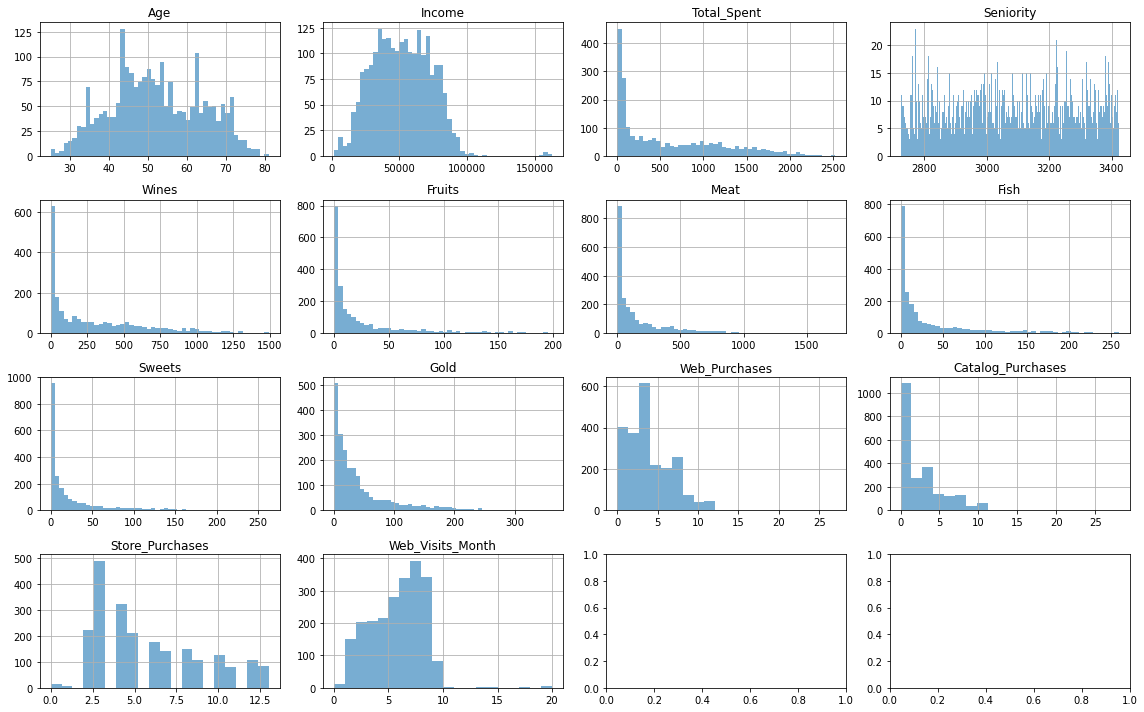

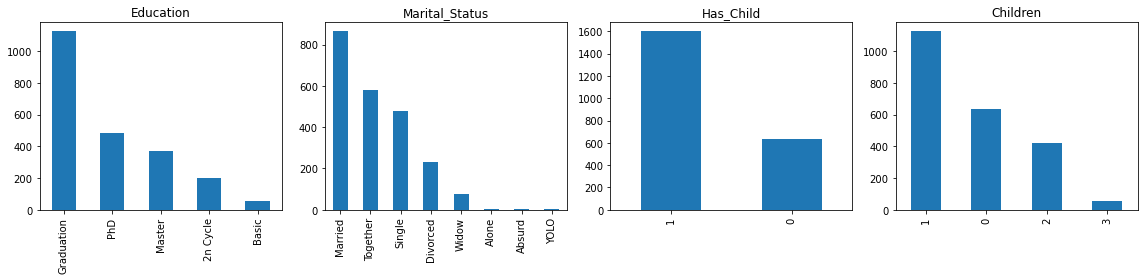

In [15]:
# Plot again after cleaning the data
plot_hist(hist_columns, bins)
plot_bars(bar_columns)

### Create Labels

In [16]:
# Adding labels to DataFrame
data['Buy_More_Online'] = (data['Web_Purchases'] > data['Store_Purchases'])*1
data['Spent_More_In_Wines_Than_Meat'] = (data['Wines'] > data['Meat'])*1

In [17]:
data.head()

,Age,Education,Marital_Status,Income,Total_Spent,Seniority,Has_Child,Children,Wines,Fruits,Meat,Fish,Sweets,Gold,Web_Purchases,Catalog_Purchases,Store_Purchases,Web_Visits_Month,Buy_More_Online,Spent_More_In_Wines_Than_Meat
ID,,,,,,,,,,,,,,,,,,,,
5524,64,Graduation,Single,58138.0,1617,3387,0,0,635,88,546,172,88,88,8,10,4,7,1,1
2174,67,Graduation,Single,46344.0,27,2837,1,2,11,1,6,2,1,6,1,1,2,5,0,1
4141,56,Graduation,Together,71613.0,776,3036,0,0,426,49,127,111,21,42,8,2,10,4,0,1
6182,37,Graduation,Together,26646.0,53,2863,1,1,11,4,20,10,3,5,2,0,4,6,0,0
5324,40,PhD,Married,58293.0,422,2885,1,1,173,43,118,46,27,15,5,3,6,5,0,1


### Prepare data

In [18]:
# Get own labels
y_online = data['Buy_More_Online']
y_spent = data['Spent_More_In_Wines_Than_Meat']

In [19]:
# Drop label columns
data.drop(columns=['Buy_More_Online', 'Spent_More_In_Wines_Than_Meat'], inplace=True)
data.head()

,Age,Education,Marital_Status,Income,Total_Spent,Seniority,Has_Child,Children,Wines,Fruits,Meat,Fish,Sweets,Gold,Web_Purchases,Catalog_Purchases,Store_Purchases,Web_Visits_Month
ID,,,,,,,,,,,,,,,,,,
5524,64,Graduation,Single,58138.0,1617,3387,0,0,635,88,546,172,88,88,8,10,4,7
2174,67,Graduation,Single,46344.0,27,2837,1,2,11,1,6,2,1,6,1,1,2,5
4141,56,Graduation,Together,71613.0,776,3036,0,0,426,49,127,111,21,42,8,2,10,4
6182,37,Graduation,Together,26646.0,53,2863,1,1,11,4,20,10,3,5,2,0,4,6
5324,40,PhD,Married,58293.0,422,2885,1,1,173,43,118,46,27,15,5,3,6,5


In [20]:
# Split data in training and testing sets (80% train - 20% test)
x_train, x_test, y_train, y_test = train_test_split(data, y_online, test_size = 0.20)

### Standarization

In [21]:
# Standarize data
numeric_columns = ['Income','Seniority','Total_Spent', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'Web_Purchases', 'Catalog_Purchases', 'Store_Purchases', 'Web_Visits_Month']
scaler = StandardScaler()

X_Train_Standarized = scaler.fit(x_train[numeric_columns]).transform(x_train[numeric_columns])
X_Test_Standarized = scaler.transform(x_test[numeric_columns])
X_Train_Standarized

array([[ 0.02932175,  1.53497929,  0.89438435, ...,  0.82494208,
         0.97403198,  0.70156506],
       [ 1.02003093, -0.68726673,  1.68575883, ...,  2.23137492,
         0.97403198, -1.37113542],
       [-1.2519    , -0.40578223, -0.92511472, ..., -0.93309897,
        -0.85952041,  0.70156506],
       ...,
       [ 1.37908932, -1.12677761,  0.28015855, ...,  2.58298313,
         2.19640023, -1.78567551],
       [ 1.09320885,  1.57448589,  2.12118035, ...,  1.17655029,
        -0.24833628, -0.12751513],
       [ 0.59425151, -1.70456158, -0.8290902 , ..., -0.58149076,
        -0.55392834, -0.95659532]])

## Unsupervised Learning

## Supervised Learning